Pipeline for nixtla time series https://nixtlaverse.nixtla.io/neuralforecast/index.html 

In [1]:
# import pkg_resources
import logging
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import AirPassengersDataset, AusBeerDataset, IceCreamHeaterDataset
from darts.metrics import mae, mape, mse
from darts.models import NBEATSModel, TFTModel, TiDEModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm, trange
# from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# set a consant figure size
plt.rcParams["figure.figsize"] = (32, 5)  # set default size of plots
fig_size = (32, 5)  # wide figures

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch23/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%load_ext autoreload 
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Visualizations will be displayed in the notebook.
%matplotlib inline

In [3]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv("data/df_TFT_preprocessed.csv")

In [4]:
# Print the number of unique patients in the DataFrame
num_unique_patients = df["unique_id"].nunique()
print(f"Number of unique patients: {num_unique_patients}")

Number of unique patients: 182


In [5]:
# Remove the last data point for each component for each patient
df = (
    df.groupby(["unique_id", "component"])
    .apply(lambda x: x.iloc[:-1])
    .reset_index(drop=True)
)

In [6]:
def anonymize_unique_id(df):
    # Create a mapping dictionary to replace digits with letters
    digit_to_letter = {str(i): chr(ord("a") + i - 1) for i in range(1, 10)}
    digit_to_letter["0"] = "j"

    # Apply the mapping to the 'unique_id' column
    df["unique_id"] = (
        df["unique_id"]
        .astype(str)
        .apply(lambda x: "".join(digit_to_letter[d] for d in x))
    )

    return df


df = anonymize_unique_id(df)

In [7]:
# Get all unique names of column 'component' and store as a list
component_names = df["component"].unique().tolist()
print(f"Unique component names: {component_names}")

Unique component names: ['Alanine_transaminase_ALAT', 'Alkaline_phosphatase_P', 'Antitrombin_P', 'Aspartate_transaminase_ASAT', 'Basophilocytes_P', 'Bilirubin_P', 'Blast_cells_B', 'C_reactive_protein', 'Calcium_ion', 'Carbamide_P', 'Coagulation_factor_II_VII_X_PP', 'Coagulation_surface_induced_APTT', 'Coagulation_tissue_factor_induced_INR', 'Creatininium_P', 'Eosinophilocytes_B', 'Erythrocyte_Volume_Fraction_EVF', 'Fibrin_D_Dimer_P', 'Fibrinogen_P', 'Glucose_Csv', 'Hemoglobin_B', 'Hydrogencarbonat', 'Lactate_dehydrogenase_LDH', 'Leukocytes_B', 'Lymphocytes_B', 'Magnesium', 'Metamyelocytes_B', 'Metamyelocytes_Myelocytes_Promyelocytes_B', 'Methotrexate_P', 'Monocytes_B', 'Myelocytes_B', 'Neutrophilocytes_B', 'Phosphate_P', 'Plasmocytes', 'Potassium_ion_P', 'Procalcitonin_PCT', 'Promyelocytes_B', 'Protein_cerebrospinal_fluid_CSF', 'Sodium_ion_P', 'Thrombocytes_B', 'Albumin_P', 'Amylase_P', 'Calcium_P', 'Glucose_concentration_pt_fasting_status_unknown', 'Immunoglobulin_G', 'Triglycerides_P

In [8]:
import logging
import sys

# Clear existing handlers
logger = logging.getLogger()
while logger.hasHandlers():
    logger.removeHandler(logger.handlers[0])

# Create and add a StreamHandler that outputs to sys.stdout
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Set the logger's level
logger.setLevel(logging.INFO)

# Test logging
logging.info("Logging is configured correctly.")

In [9]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'unique_id', 'sex', 'age_at_sample',
       'weight_change_cycles', 'transer', 'transth', 'component', 'value',
       'unit', 'days_since_first_infusion', 'infno', 'infno_day'],
      dtype='object')


In [10]:
# Calculate the mean age at sample for each patient and round to one decimal place
mean_age_at_sample = df.groupby("unique_id")["age_at_sample"].mean().round(1)

# Merge the mean age back into the original DataFrame
df = df.merge(mean_age_at_sample.rename("age"), left_on="unique_id", right_index=True)

# Create a DataFrame named df_static with unique ID as index and columns 'age' and 'sex'
df_static = df[["unique_id", "age", "sex"]].drop_duplicates().set_index("unique_id")

# Drop the original columns
df = df.drop(
    columns=["age_at_sample", "unit", "infno", "infno_day", "transer", "transth"]
)

In [11]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'unique_id', 'sex', 'weight_change_cycles',
       'component', 'value', 'days_since_first_infusion', 'age'],
      dtype='object')


In [12]:
df_static.head()

,age,sex
unique_id,,
bjjhajh,3.0,1
bjjhaji,8.8,2
bjjhaab,5.8,1
bjjhaaf,2.8,1
bjjhabj,4.4,2


In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


class TimeSeriesPreprocessor:
    def __init__(
        self,
        target_column=None,
        complete_timeline=False,
        encode_temporal_distance=False,
        add_decay=False,
        fill_residual_nan=False,
        exclude_columns=None,
    ):
        self.target_column = target_column
        self.complete_timeline = complete_timeline
        self.encode_temporal_distance = encode_temporal_distance
        self.add_decay = add_decay
        self.decay_models = {}
        self.fill_residual_nan = fill_residual_nan
        self.exclude_columns = exclude_columns or []

    def _initial_preparation(self, X):
        X["ds"] = pd.to_datetime(X["ds"])

        # Create a new column 'normalized_time_days' to store the normalized time in days
        X["normalized_time_days"] = X.groupby("unique_id")["ds"].transform(
            lambda x: (x - x.min()).dt.days
        )

        # Find the minimum normalized_time_days for each patient
        min_normalized_time_days = X.groupby("unique_id")["normalized_time_days"].min()

        # Subtract the minimum normalized_time_days from each patient's normalized_time_days
        X["normalized_time"] = X.groupby("unique_id")["normalized_time_days"].transform(
            lambda x: x - min_normalized_time_days[x.name]
        )

        # Pivot the DataFrame to wide format
        df = X.pivot_table(
            index=["unique_id", "normalized_time", "age", "sex"],
            columns="component",
            values="value",
            aggfunc="first",
            sort=["unique_id", "normalized_time"],
        ).reset_index()
        return df

    def interpolate_group(self, group):
        for column in group.columns:
            if group[column].dtype.kind in "fi":  # Check if the column is numeric
                # Apply linear interpolation
                group[column] = group[column].interpolate(method="linear")
        return group

    def prepare_and_process(self, X):
        df = self._initial_preparation(X)

        # Rename the target column to 'y' if specified
        if self.target_column is not None and self.target_column not in df.columns:
            raise ValueError(
                f"Target column '{self.target_column}' not found in DataFrame."
            )
        else:
            df = df.rename(columns={self.target_column: "y"})

        if self.complete_timeline:
            df = self._complete_timeline(df)

        if self.encode_temporal_distance or self.add_decay:
            df = self._simple_missingness_encoding(df)
            df = self._encode_temporal_distance(df)

        if self.add_decay:
            self._estimate_decay_parameters(df)
            df = self._apply_decay(df)

        if self.fill_residual_nan:
            df = self._fill_residual_nan(df)

        return df

    def _complete_timeline(self, df):
        print("Completing the timeline...")
        max_normalized_time = df.groupby("unique_id")["normalized_time"].max()
        complete_timeline = pd.concat(
            [
                pd.DataFrame(
                    {"unique_id": unique_id, "normalized_time": np.arange(max_time + 1)}
                )
                for unique_id, max_time in max_normalized_time.items()
            ],
            ignore_index=True,
        )
        df = (
            pd.merge(
                complete_timeline, df, on=["unique_id", "normalized_time"], how="left"
            )
            .set_index(["unique_id", "normalized_time"])
            .reset_index()
        )
        print("Timeline completed.")
        return df

    def _simple_missingness_encoding(self, df):
        missingness_indicators = (
            df.loc[:, ~df.columns.isin(self.exclude_columns)].isna().astype(int)
        )
        missingness_indicators = missingness_indicators.add_suffix("_missing")
        df = pd.concat([df, missingness_indicators], axis=1)
        return df

    def _encode_temporal_distance(self, df):
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns and not col.endswith("_missing")
        ]
        temporal_distance_data = {}
        for col in feature_columns:
            if not col.endswith("_delta"):
                temporal_distance_data[col + "_delta"] = df.groupby("unique_id")[
                    col
                ].transform(
                    lambda x: x.notna()
                    .cumsum()
                    .where(x.notna(), x.notna().cumsum().ffill().fillna(0) + 1)
                )
        temporal_distance_df = pd.DataFrame(temporal_distance_data, index=df.index)
        df = pd.concat([df, temporal_distance_df], axis=1)
        return df

    def _estimate_decay_parameters(self, df):
        print("Estimating decay parameters...")
        decay_params = {}

        for feature in [
            col
            for col in df.columns
            if not col.endswith(("_delta", "_missing", "unique_id", "normalized_time"))
            and col not in self.exclude_columns
        ]:
            df[feature + "_last"] = df.groupby("unique_id")[
                feature
            ].ffill()  # Calculate the last observed value on the fly for training
            # Prepare the training data
            feature_df = df[[feature + "_delta", feature, feature + "_last"]].dropna()
            X_train = feature_df[feature + "_delta"].values
            y_train = feature_df[feature].values
            y_last = feature_df[feature + "_last"].values
            # Normalize the _delta values using Min-Max scaling
            X_train_normalized = (X_train - X_train.min()) / (
                X_train.max() - X_train.min()
            )
            print(
                f"Range of {feature}_delta: [{feature_df[feature + '_delta'].min()}, {feature_df[feature + '_delta'].max()}]"
            )

            # Objective function to minimize the loss
            def objective(params):
                W, b = params
                decay_factor = np.exp(-np.maximum(0, W * X_train_normalized + b))
                # loss = np.mean((y_train - (y_last * decay_factor))**2) # Mean Squared Error
                loss = np.mean(
                    np.abs(y_train - (y_last * decay_factor))
                )  # Mean Absolute Error

                return loss

            # Initial guess for the parameters
            initial_params = [0.0, 0.0]

            # Minimize the objective function using different optimization methods
            methods = ["L-BFGS-B", "TNC", "SLSQP"]
            best_result = None
            best_loss = float("inf")
            best_method = None

            for method in methods:
                try:
                    result = minimize(
                        objective,
                        initial_params,
                        method=method,
                        bounds=[(None, None), (None, None)],
                    )

                    if result.success and result.fun < best_loss:
                        best_result = result
                        best_loss = result.fun
                        best_method = method
                except Exception as e:
                    print(
                        f"Optimization failed for feature '{feature}' with method '{method}': {str(e)}"
                    )

            if best_result is not None:
                W_opt, b_opt = best_result.x
                decay_params[feature] = {"W": W_opt, "b": b_opt, "method": best_method}
                print(f"Best optimization method for '{feature}': {best_method}")
                print(f"Decay parameters for '{feature}': W = {W_opt}, b = {b_opt}")
            else:
                print(f"Optimization failed for feature '{feature}'")

            # Clean up the temporary column
            df.drop(columns=[feature + "_last"], inplace=True)

        self.decay_params = decay_params
        print("Decay parameters estimated.")

    def _apply_decay(self, df):
        print("Applying decay to features...")
        df_copy = df.copy()

        last_columns = {}
        for feature in self.decay_params:
            last_columns[feature + "_last"] = df_copy.groupby("unique_id")[
                feature
            ].ffill()

        last_df = pd.DataFrame(last_columns)

        for feature in self.decay_params:
            W, b = self.decay_params[feature]["W"], self.decay_params[feature]["b"]
            decay_factor = np.exp(-np.maximum(0, W * df_copy[feature + "_delta"] + b))
            df_copy[feature] = last_df[feature + "_last"] * decay_factor
            df_copy[feature] = df_copy[feature].fillna(last_df[feature + "_last"])

        df_copy = df_copy.drop(
            columns=[col for col in df_copy.columns if col.endswith("_last")]
        )

        print("Decay applied to features.")
        return df_copy

    def _fill_residual_nan(self, df):
        print("Filling residual NaN values...")
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns and not col.endswith("_missing")
        ]
        df[feature_columns] = df[feature_columns].fillna(0)
        return df


preprocessor = TimeSeriesPreprocessor(
    target_column=None,
    complete_timeline=False,
    encode_temporal_distance=True,
    add_decay=True,
    fill_residual_nan=True,
    exclude_columns=["unique_id", "normalized_time", "range_index", "sex", "age"],
)
processed_df = preprocessor.prepare_and_process(df)

Estimating decay parameters...
Range of Alanine_transaminase_ALAT_delta: [1, 142]
Best optimization method for 'Alanine_transaminase_ALAT': SLSQP
Decay parameters for 'Alanine_transaminase_ALAT': W = -0.04680166745832148, b = -0.15827737738897132
Range of Albumin_P_delta: [1, 128]
Best optimization method for 'Albumin_P': SLSQP
Decay parameters for 'Albumin_P': W = -0.008676788847865002, b = -0.031284106263486315
Range of Alkaline_phosphatase_P_delta: [1, 118]
Best optimization method for 'Alkaline_phosphatase_P': SLSQP
Decay parameters for 'Alkaline_phosphatase_P': W = -0.03771202404594976, b = -0.16732011180129575
Range of Amylase_P_delta: [1, 63]
Best optimization method for 'Amylase_P': SLSQP
Decay parameters for 'Amylase_P': W = -0.01336060273273044, b = -0.06848365852868861
Range of Amylase_P_pancreatic_type_delta: [1, 62]
Best optimization method for 'Amylase_P_pancreatic_type': SLSQP
Decay parameters for 'Amylase_P_pancreatic_type': W = -0.006294299612874853, b = -0.03139937538

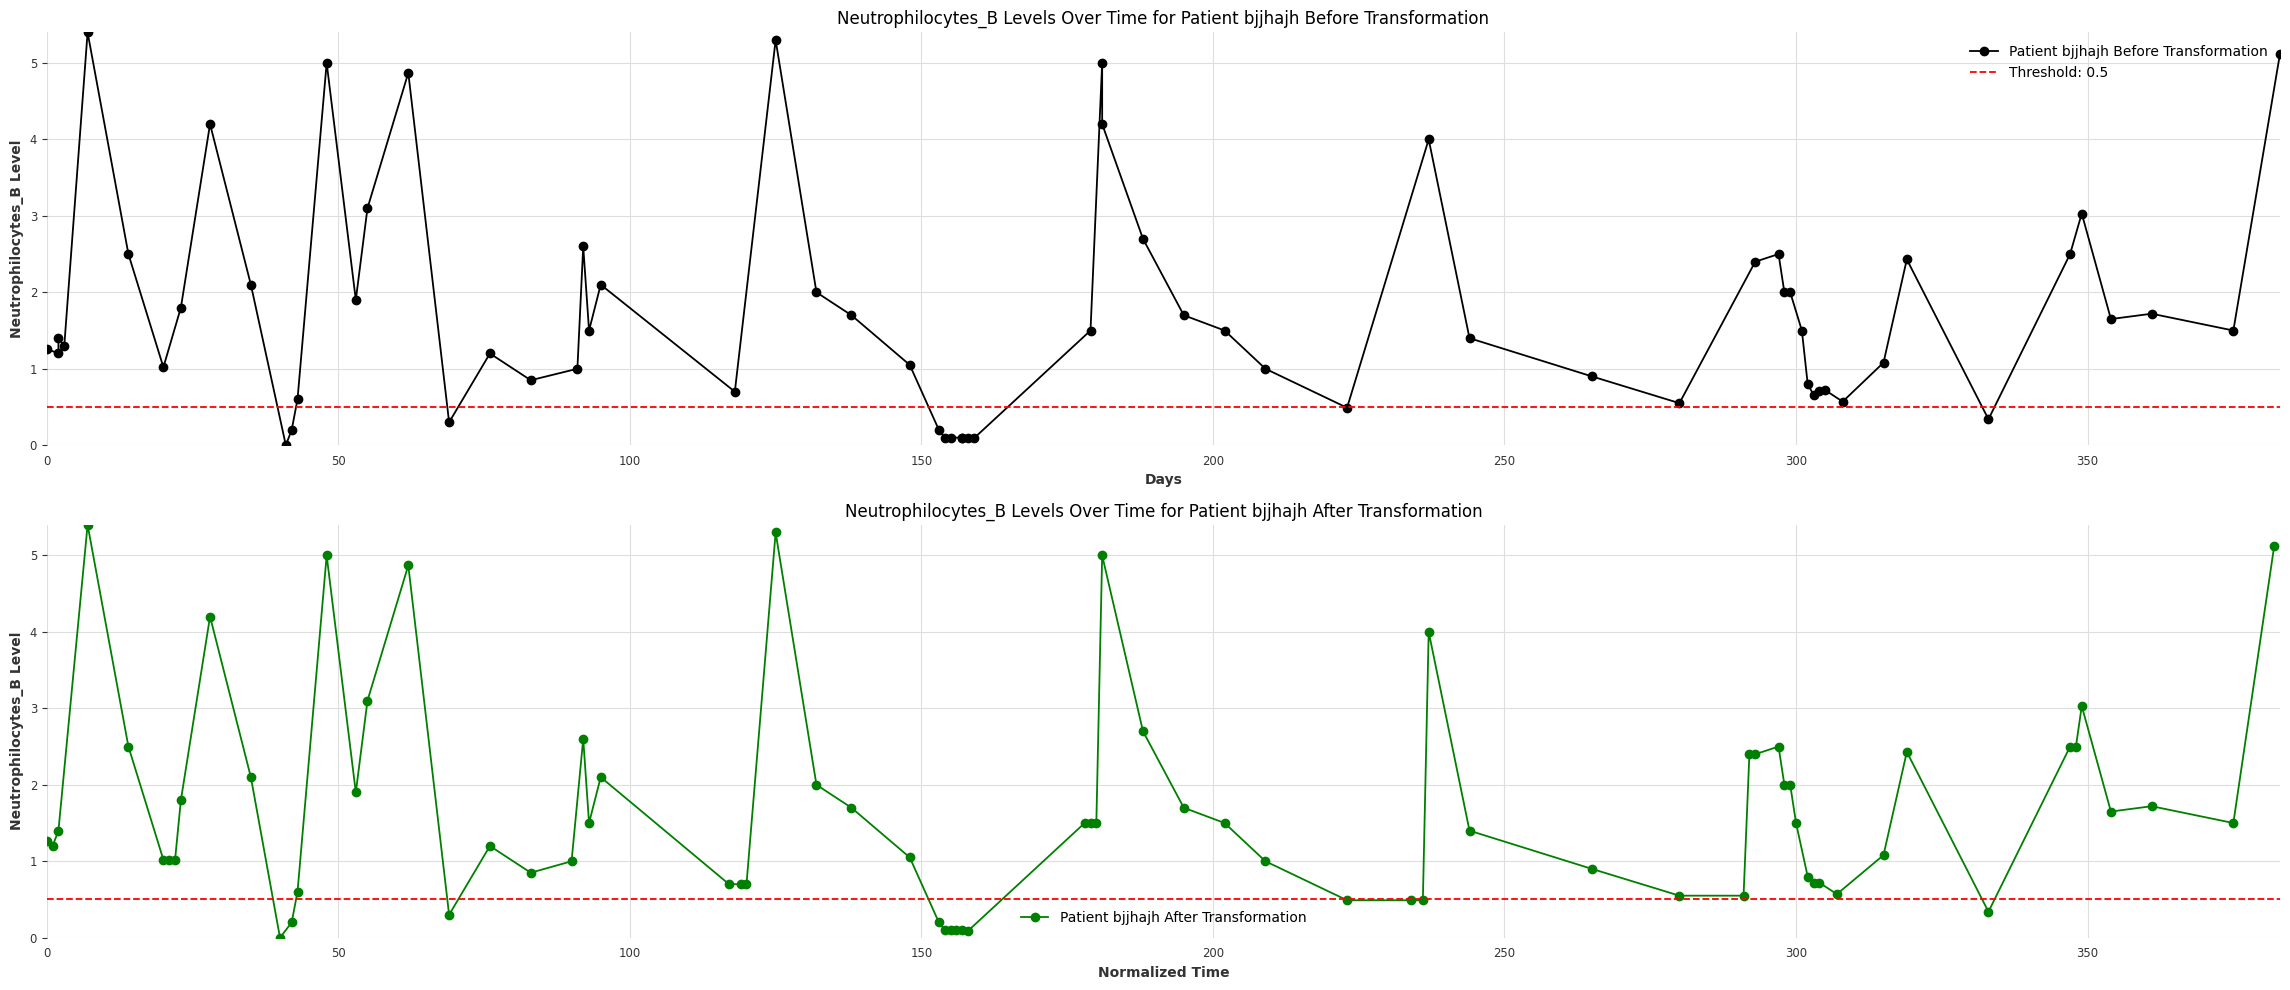

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your original DataFrame and wide_df_complete_interpolated is the transformed DataFrame


# Function to filter patient data before transformation
def filterPatientANC(unique_id, component, df):
    data = df[
        (df["unique_id"] == unique_id) & (df["component"] == component)
    ].sort_values(by="days_since_first_infusion")
    return data


def filterPatientANC_transformed(unique_id, df):
    data = df[(df["unique_id"] == unique_id)]
    # Adjusted to directly use the 'Neutrophilocytes_B' column renamed to 'y' instead of a variable component name
    component_data = data[["normalized_time", "Neutrophilocytes_B"]].dropna()
    return component_data


# Replace 'bjjhajh' with the actual unique_id you're interested in
unique_id = "bjjhajh"  # Placeholder, replace with actual integer ID
component = "Neutrophilocytes_B"

# Filter data before and after transformation
data_org = filterPatientANC(unique_id, component, df)
data_transformed = filterPatientANC_transformed(unique_id, processed_df)

# Determine the common x and y limits
x_min = min(
    data_org["days_since_first_infusion"].min(),
    data_transformed["normalized_time"].min(),
)
x_max = max(
    data_org["days_since_first_infusion"].max(),
    data_transformed["normalized_time"].max(),
)
y_min = min(data_org["value"].min(), data_transformed["Neutrophilocytes_B"].min())
y_max = max(data_org["value"].max(), data_transformed["Neutrophilocytes_B"].max())

# Plotting
plt.figure(figsize=(23, 10))

# Plot before transformation
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(
    data_org["days_since_first_infusion"],
    data_org["value"],
    marker="o",
    linestyle="-",
    label=f"Patient {unique_id} Before Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} Before Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--", label="Threshold: 0.5")
plt.xlabel("Days")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

# Plot after transformation
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(
    data_transformed["normalized_time"],
    data_transformed["Neutrophilocytes_B"],
    marker="o",
    linestyle="-",
    color="green",
    label=f"Patient {unique_id} After Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} After Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--")
plt.xlabel("Normalized Time")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
def test_decay_application(processed_df, df):
    missing_before = df.isna().sum().sum()
    missing_after = processed_df.isna().sum().sum()

    print(f"Missing values before transformation: {missing_before}")
    print(f"Missing values after transformation: {missing_after}")

    # Assuming decay models should reduce the number of missing values
    if missing_after < missing_before:
        print("Test passed: Decay models applied successfully.")
    else:
        print("Test failed: Decay models may not have been applied correctly.")


test_decay_application(processed_df, df)

Missing values before transformation: 0
Missing values after transformation: 0
Test failed: Decay models may not have been applied correctly.


In [16]:
# Count the number of rows where all columns from the first to the last (excluding the first column) have NaN values
num_rows_all_nan = processed_df.iloc[:, 2:-1].isna().all(axis=1).sum()
print(
    f"Number of rows where all columns from components are NaN values: {num_rows_all_nan}"
)

Number of rows where all columns from components are NaN values: 0


In [17]:
processed_df.shape

(17799, 193)

In [18]:
processed_df.columns.tolist()

['unique_id',
 'normalized_time',
 'age',
 'sex',
 'Alanine_transaminase_ALAT',
 'Albumin_P',
 'Alkaline_phosphatase_P',
 'Amylase_P',
 'Amylase_P_pancreatic_type',
 'Antitrombin_P',
 'Aspartate_transaminase_ASAT',
 'Basophilocytes_P',
 'Bilirubin_P',
 'Blast_cells_B',
 'C_reactive_protein',
 'Calcium_P',
 'Calcium_P_Adjusted',
 'Calcium_ion',
 'Carbamide_P',
 'Chloride_P',
 'Cholesterol_ester_P',
 'Cholesterol_ester_in_HDL',
 'Cholesterol_ester_in_LDL',
 'Coagulation_factor_II_VII_X_PP',
 'Coagulation_surface_induced_APTT',
 'Coagulation_tissue_factor_induced_INR',
 'Creatininium_P',
 'Eosinophilocytes_B',
 'Erythrocyte_Volume_Fraction_EVF',
 'Erythrocytes_B',
 'Erythrocytes_mean_corpuscular_volume_MCV',
 'Ferritin',
 'Fibrin_D_Dimer_P',
 'Fibrinogen_P',
 'Glucose_Csv',
 'Glucose_concentration_pt_fasting_status_unknown',
 'Hemoglobin_B',
 'Hemoglobin_HbA1c',
 'Hemoglobin_MCHC',
 'Hydrogencarbonat',
 'Immunoglobulin_A',
 'Immunoglobulin_G',
 'Immunoglobulin_M',
 'Lactate_dehydrogenase_

In [19]:
processed_df.shape

(17799, 193)

In [20]:
# calculate the % of nan in each column
nan_percentages = processed_df.isna().mean() * 100
nan_percentages_top10 = nan_percentages.nlargest(10)
print("\nTop 10 columns with highest percentage of NaNs:")
print(nan_percentages_top10)


Top 10 columns with highest percentage of NaNs:
unique_id                    0.0
normalized_time              0.0
age                          0.0
sex                          0.0
Alanine_transaminase_ALAT    0.0
Albumin_P                    0.0
Alkaline_phosphatase_P       0.0
Amylase_P                    0.0
Amylase_P_pancreatic_type    0.0
Antitrombin_P                0.0
dtype: float64


In [21]:
# Check if any columns with name in component_names have all 0 or non-unique values for each unique_id


for col in component_names:
    if col in processed_df.columns:
        # Group by unique_id and check if the column has all 0 or non-unique values
        is_invalid = processed_df.groupby("unique_id")[col].apply(
            lambda x: x.eq(0).all() or x.nunique() == 1
        )

        if is_invalid.any():
            print(f"Column '{col}' has all 0 or non-unique values for some unique_ids.")
        # else:
        #     print(f"Column '{col}' has valid values for all unique_ids.")
    else:
        print(f"Column '{col}' not found in the DataFrame.")

Column 'Alkaline_phosphatase_P' has all 0 or non-unique values for some unique_ids.
Column 'Antitrombin_P' has all 0 or non-unique values for some unique_ids.
Column 'Aspartate_transaminase_ASAT' has all 0 or non-unique values for some unique_ids.
Column 'Basophilocytes_P' has all 0 or non-unique values for some unique_ids.
Column 'Bilirubin_P' has all 0 or non-unique values for some unique_ids.
Column 'Blast_cells_B' has all 0 or non-unique values for some unique_ids.
Column 'Calcium_ion' has all 0 or non-unique values for some unique_ids.
Column 'Carbamide_P' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_factor_II_VII_X_PP' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_surface_induced_APTT' has all 0 or non-unique values for some unique_ids.
Column 'Coagulation_tissue_factor_induced_INR' has all 0 or non-unique values for some unique_ids.
Column 'Erythrocyte_Volume_Fraction_EVF' has all 0 or non-unique values for some unique_ids.
Co

In [22]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

# if 'ds' not in processed_df.columns:
#     raise KeyError("Column 'ds' not found in the DataFrame.")

# data = (processed_df.merge((processed_df[['ds']].drop_duplicates(ignore_index=True)
# .rename_axis('time_idx')).reset_index(), on = ['ds']))

In [23]:
# # fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

In [24]:
# Create a index 'range_index' with a RangeIndex for each patient
processed_df = processed_df.set_index(
    processed_df.groupby("unique_id")["normalized_time"]
    .transform(lambda x: pd.RangeIndex(len(x)))
    .rename("range_index")
)

In [25]:
# print the min, mean and max length of range_index and normalized_time

# Get the length of each unique_id's data
lengths = processed_df.groupby("unique_id").size()
print(f"Range index lengths:")
print(f"  Min: {lengths.min()}")
print(f"  Mean: {lengths.mean():.2f}")
print(f"  Max: {lengths.max()}")

# Get the min, mean, and max of normalized_time for each unique_id
normalized_time_stats = processed_df.groupby("unique_id")["normalized_time"].agg(
    ["min", "mean", "max"]
)

print(f"\nNormalized time ranges:")
print(
    f"  Min range: {normalized_time_stats['min'].min()} - {normalized_time_stats['max'].min()}"
)
print(
    f"  Mean range: {normalized_time_stats['min'].mean():.2f} - {normalized_time_stats['max'].mean():.2f}"
)
print(
    f"  Max range: {normalized_time_stats['min'].max()} - {normalized_time_stats['max'].max()}"
)

Range index lengths:
  Min: 58
  Mean: 97.80
  Max: 155

Normalized time ranges:
  Min range: 0 - 343
  Mean range: 0.00 - 385.37
  Max range: 0 - 447


In [26]:
processed_df.head()

,unique_id,normalized_time,age,sex,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,Amylase_P_pancreatic_type,Antitrombin_P,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
range_index,,,,,,,,,,,,,,,,,,,,,
0,bjaaaaa,0,15.1,2,238.0,32.0,82.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,bjaaaaa,1,15.1,2,140.0,32.0,82.0,0.0,0.0,0.0,...,1,1,1,2,2,1,1,1,1,1
2,bjaaaaa,2,15.1,2,147.0,30.0,71.0,0.0,0.0,0.0,...,1,1,1,2,2,1,1,1,1,1
3,bjaaaaa,5,15.1,2,226.0,29.0,94.0,0.0,0.0,0.0,...,1,1,1,3,3,1,1,1,1,1
4,bjaaaaa,7,15.1,2,273.0,30.0,102.0,0.0,0.0,0.0,...,1,1,1,4,4,1,1,1,1,1


In [27]:
# Print the name of the index
print(f"Index name: {processed_df.index.name}")

Index name: range_index


In [28]:
# Check if 'range_index' is an index or a column
if "range_index" in processed_df.columns:
    print("'range_index' is a column in the DataFrame.")
elif "range_index" in processed_df.index.names:
    print("'range_index' is an index level in the DataFrame.")
else:
    print("'range_index' is not found as a column or index in the DataFrame.")

'range_index' is an index level in the DataFrame.


In [29]:
# # # Flatten the multi-level index and reset the index
# processed_df = processed_df.reset_index()


In [30]:
processed_df.head()

,unique_id,normalized_time,age,sex,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,Amylase_P_pancreatic_type,Antitrombin_P,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
range_index,,,,,,,,,,,,,,,,,,,,,
0,bjaaaaa,0,15.1,2,238.0,32.0,82.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,bjaaaaa,1,15.1,2,140.0,32.0,82.0,0.0,0.0,0.0,...,1,1,1,2,2,1,1,1,1,1
2,bjaaaaa,2,15.1,2,147.0,30.0,71.0,0.0,0.0,0.0,...,1,1,1,2,2,1,1,1,1,1
3,bjaaaaa,5,15.1,2,226.0,29.0,94.0,0.0,0.0,0.0,...,1,1,1,3,3,1,1,1,1,1
4,bjaaaaa,7,15.1,2,273.0,30.0,102.0,0.0,0.0,0.0,...,1,1,1,4,4,1,1,1,1,1


### Read the 1. Defining static covariates
https://unit8co.github.io/darts/examples/15-static-covariates.html#

### remenber tide might not be good for this

### Set up the pytorch forecasting TFT using the masking - move along 



In [31]:
# Create a list of all column names except 'unique_id'
component_names = [
    col
    for col in processed_df.columns
    if col != "unique_id" and col != "sex" and col != "age"
]
print(f"Number of components: {len(component_names)}")

Number of components: 190


In [32]:
def test_static_columns(df, group_col, static_cols):
    for static_col in static_cols:
        unique_values_per_group = df.groupby(group_col)[static_col].nunique()
        if (unique_values_per_group != 1).any():
            raise ValueError(
                f"Static column '{static_col}' has multiple unique values within a group."
            )
    print("Static column test passed.")


# Usage
static_cols = ["sex", "age"]
test_static_columns(processed_df, "unique_id", static_cols)

Static column test passed.


In [33]:
# Create a list of unique patient IDs
unique_ids = processed_df["unique_id"].unique()

# Get the last 100 unique IDs for testing
# unique_ids = unique_ids[:40]

# Split the unique IDs into training, validation, and test sets
train_ids, val_test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5, random_state=42)

# Create TimeSeries objects for training, validation, and test sets
train_list = []
val_list = []
test_list = []

for unique_id in unique_ids:
    patient_data = processed_df[processed_df["unique_id"] == unique_id]
    patient_static_covariates = patient_data[["sex", "age"]].iloc[
        0
    ]  # Get the first row for the patient's static covariates
    patient_series = TimeSeries.from_dataframe(
        patient_data,
        time_col=None,  # Use the DataFrame's index as the time index
        value_cols=component_names,
        static_covariates=patient_static_covariates,
        freq=1,  # Specify the frequency as an integer value
    )

    if unique_id in train_ids:
        train_list.append(patient_series)
    elif unique_id in val_ids:
        val_list.append(patient_series)
    else:
        test_list.append(patient_series)

# Convert the TimeSeries objects to float32
train_list = [ts.astype(np.float32) for ts in train_list]
val_list = [ts.astype(np.float32) for ts in val_list]
test_list = [ts.astype(np.float32) for ts in test_list]

print(f"Length of train_list: {len(train_list)}")
print(f"Length of val_list: {len(val_list)}")
print(f"Length of test_list: {len(test_list)}")

Length of train_list: 145
Length of val_list: 18
Length of test_list: 19


<Axes: xlabel='range_index'>

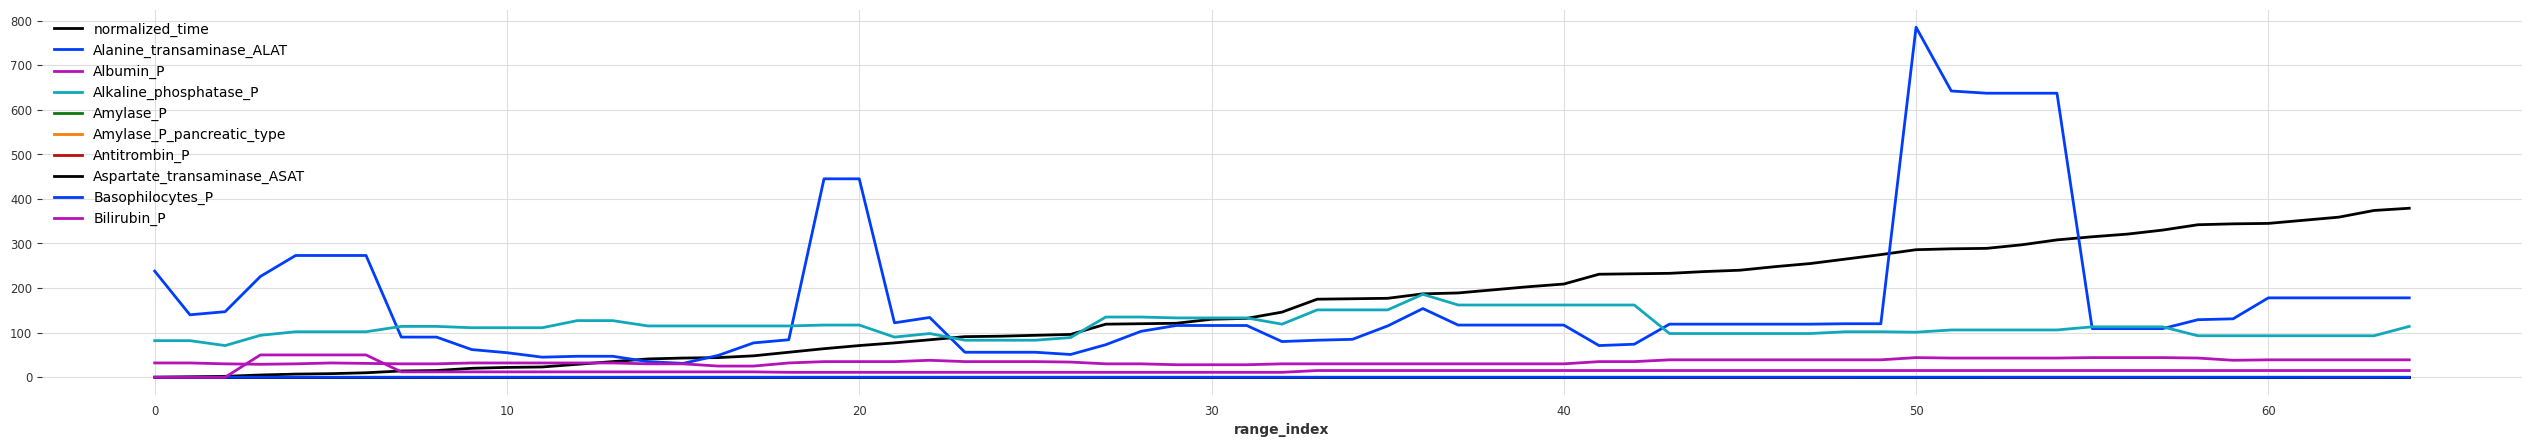

In [34]:
train_list[0].plot()

In [35]:
# from sklearn.model_selection import train_test_split

# # Create a list of unique patient IDs
# unique_ids = processed_df['unique_id'].unique()

# # Split the unique IDs into training, validation, and test sets
# train_ids, val_test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
# val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5, random_state=42)

# # Limit the number of patients in the training set to 20
# train_ids = train_ids[:20]

# # Assuming your DataFrame is named 'processed_df'
# train_series = TimeSeries.from_group_dataframe(
#        processed_df[processed_df['unique_id'].isin(train_ids)],
#        group_cols='unique_id',
#        time_col=None,
#        value_cols=component_names,
#        static_cols=['sex', 'age'],
#        freq=1
#    )

# val_series = TimeSeries.from_group_dataframe(
#     processed_df[processed_df['unique_id'].isin(val_ids)],
#     group_cols='unique_id',
#     time_col=None,
#     value_cols=component_names,
#     static_cols=['sex', 'age'],
#     freq=1
# )

# test_series = TimeSeries.from_group_dataframe(
#     processed_df[processed_df['unique_id'].isin(test_ids)],
#     group_cols='unique_id',
#     time_col=None,
#     value_cols=component_names,
#     static_cols=['sex', 'age'],
#     freq=1
# )

# # Convert the TimeSeries objects to float32
# train_list = [ts.astype(np.float32) for ts in train_series]
# val_list = [ts.astype(np.float32) for ts in val_series]
# test_list = [ts.astype(np.float32) for ts in test_series]

# print(f"Length of train_list: {len(train_list)}")
# print(f"Length of val_list: {len(val_list)}")
# print(f"Length of test_list: {len(test_list)}")

In [36]:
train_list[0].head()

<TimeSeries (DataArray) (range_index: 5, component: 190, sample: 1)> Size: 4kB
array([[[0.000e+00],
        [2.380e+02],
        [3.200e+01],
        [8.200e+01],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [2.000e-02],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [5.500e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
...
        [1.000e+00],
        [1.000e+00],
        [4.000e+00],
        [4.000e+00],
        [1.000e+00],
        [4.000e+00],
        [2.000e+00],
        [1.000e+00],
        [4.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [4.000e+00],
        [4.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00],
        [1.000e+00]]], dtype=float32)
Coordinates:
  * range_index  (range_index) int64 40B 0 1 2 3 4
  * component    (component) object 2kB 'normalized_time' ... 'eGFR_DSKB_DNS_...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  sex   age\nglobal_components  2.0 ...
    hierarchy:          None

In [37]:
# Count the number of rows in each list
train_rows = sum(len(ts) for ts in train_list)
val_rows = sum(len(ts) for ts in val_list)
test_rows = sum(len(ts) for ts in test_list)

# Calculate the total number of rows
total_rows = train_rows + val_rows + test_rows

print(f"Number of rows in train_list: {train_rows}")
print(f"Number of rows in val_list: {val_rows}")
print(f"Number of rows in test_list: {test_rows}")
print(f"Total number of rows: {total_rows}")

Number of rows in train_list: 14318
Number of rows in val_list: 1703
Number of rows in test_list: 1778
Total number of rows: 17799


In [38]:
# Check the number of rows with NaN values in each column
nan_rows_per_column = processed_df.isna().sum()

# Count the total number of rows with at least one NaN value
total_nan_rows = processed_df.isna().any(axis=1).sum()

print(f"Number of rows with NaN values per column:\n{nan_rows_per_column}")
print(f"\nTotal number of rows with at least one NaN value: {total_nan_rows}")

Number of rows with NaN values per column:
unique_id                                          0
normalized_time                                    0
age                                                0
sex                                                0
Alanine_transaminase_ALAT                          0
                                                  ..
Thyrotropin_TSH_delta                              0
Triacylglycerol_lipase_delta                       0
Triglycerides_P_pt_fasting_status_unknown_delta    0
Urate_delta                                        0
eGFR_DSKB_DNS_2009_delta                           0
Length: 193, dtype: int64

Total number of rows with at least one NaN value: 0


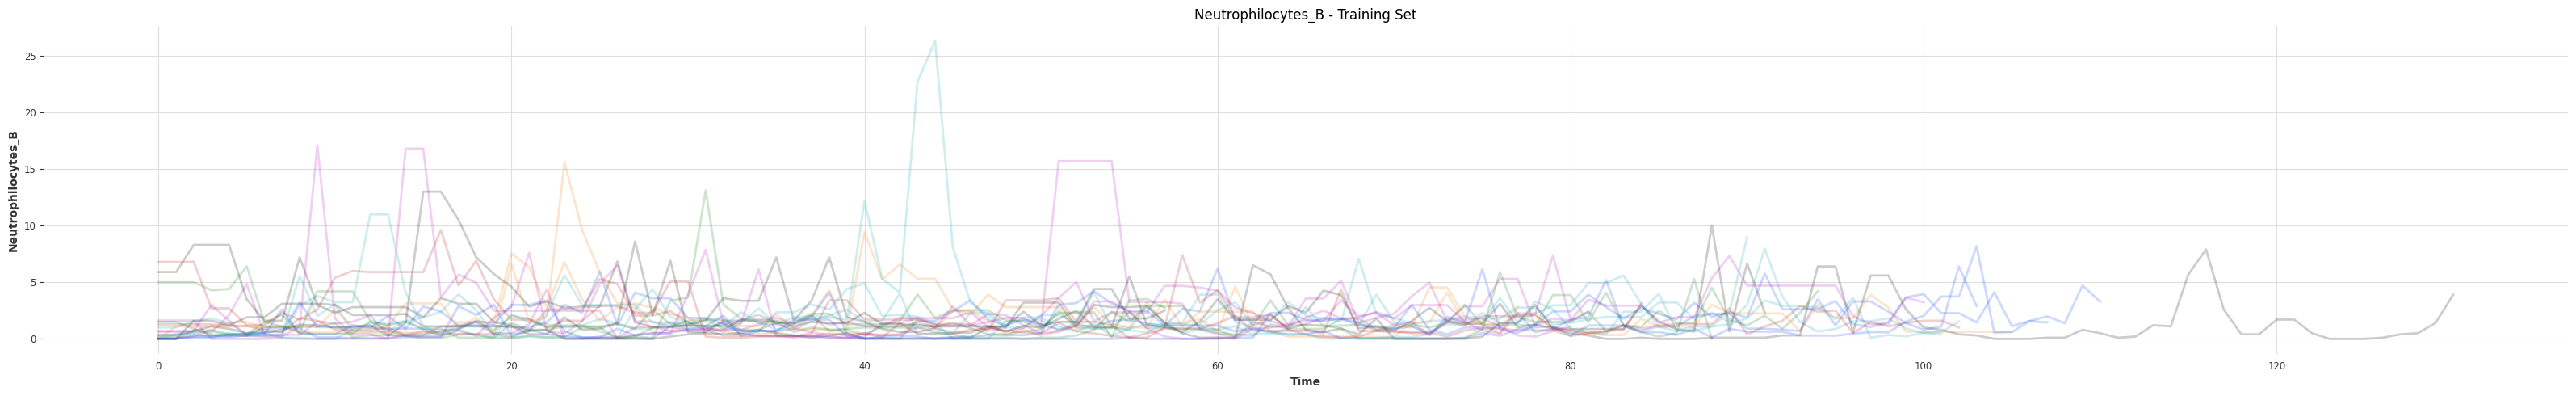

In [39]:
# Choose a component to plot
component_to_plot = "Neutrophilocytes_B"

# Plot the chosen component for the training set
fig, ax = plt.subplots(1, 1, figsize=fig_size)
for train_series in test_list:
    train_series[component_to_plot].plot(ax=ax, label="_nolegend_", alpha=0.2)
ax.set_xlabel("Time")
ax.set_ylabel(component_to_plot)
ax.set_title(f"{component_to_plot} - Training Set")
plt.tight_layout()
plt.show()

In [40]:
# optimizer_kwargs = {
#     "lr": 1e-2,
# }

# # early stopping
# # this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
# early_stopping_args = {
#     "monitor": "val_loss",
#     "patience": 2,
#     "min_delta": 1e-3,
#     "mode": "min",
# }

# # PyTorch Lightning Trainer arguments
# pl_trainer_kwargs = {
#     "gradient_clip_val": 1,
#     "max_epochs": 10,
#     "accelerator": "auto",
#     "callbacks": [
#         EarlyStopping(**early_stopping_args),
#         TFMProgressBar(enable_train_bar_only=True),
#     ],
# }

# # learning rate scheduler
# lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
# lr_scheduler_kwargs = {
#     "gamma": 0.99,
# }

# from torch.optim.lr_scheduler import StepLR
# # Define the learning rate scheduler class and arguments
# # lr_scheduler_cls = StepLR
# # lr_scheduler_kwargs = {'step_size': 30, 'gamma': 0.1}


# common_model_args = {
#     "input_chunk_length": 40,  # lookback window (12 hours) depending
#     "output_chunk_length": 10,  # forecast/lookahead window (12 hours)
#     # "optimizer_kwargs": optimizer_kwargs,
#     "pl_trainer_kwargs": pl_trainer_kwargs,
#     "lr_scheduler_cls": lr_scheduler_cls,
#     "lr_scheduler_kwargs": lr_scheduler_kwargs,
#     "likelihood": None,  # use a likelihood for probabilistic forecasts
#     "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
#     "force_reset": True,
#     # "batch_size": 256,
#     "random_state": 42,
# }
# run_hyperparameter_tuning = True

In [41]:
# Scale the series
# scaler = Scaler()
# train_scaled = scaler.fit_transform(train_list)
# val_scaled = scaler.transform(val_list)
# test_scaled = scaler.transform(test_list)

# Working 
# for train_series, val_series in zip(train_scaled, val_scaled):
#     model = TiDEModel(
#     input_chunk_length = 40 ,# Specifies the length of the input chunk, which is the number of time steps fed into the model at each time step.
#     output_chunk_length = 10, #Specifies the length of the output chunk
#     num_encoder_layers = 2, #Specifies the number of layers in the encoder.
#     num_decoder_layers = 2, # Specifies the number of layers in the decoder.
#     decoder_output_dim = 30, #Specifies the output dimension of the decoder.
#     hidden_size = 512, #Specifies the size of the hidden layers.
#     temporal_decoder_hidden = 32, #Specifies the size of the hidden layers in the temporal decoder.
#     use_layer_norm = True, #Specifies whether to use layer normalization.
#     dropout = 0.9, #Specifies the dropout probability.
#     random_state = 42, #Specifies the random state for reproducibility
#     use_static_covariates=True,
#     use_reversible_instance_norm=True,
#     )

#     model.fit(series=train_scaled, val_series=val_scaled, epochs=5, verbose=True)

In [42]:
# # Get predictions for a specific patient
# patient_id = 'bjaaaaa'  # Specify the unique_id of the patient you want to get predictions for

# patient_data = processed_df[processed_df['unique_id'] == patient_id]
# patient_static_covariates = patient_data[['sex', 'age']].iloc[0]

# # Select the desired components
# selected_components = ['Leukocytes_B', 'Neutrophilocytes_B', 'Aspartate_transaminase_ASAT', 'Alanine_transaminase_ALAT', 'Creatininium_P']

# patient_series = TimeSeries.from_dataframe(
#     patient_data,
#     time_col=None,
#     value_cols=component_names,
#     static_covariates=patient_static_covariates,
#     freq=1
# )

# patient_scaled = scaler.transform(patient_series)

# # Convert the data to float32
# patient_scaled = patient_scaled.astype(np.float32)

# # Specify the day for which you want to get the actual values
# day = 50

# # Specify the number of days before and after the specified day to plot
# days_before = 10
# days_after = 36

# # Get the actual values for the specified range of days
# actual_values = patient_series[day-days_before:day+days_after]

# # Get the scaled patient series up to the specified day
# patient_scaled_up_to_day = patient_scaled[:day+1]

# # Predict the next 36 values starting from the specified day
# patient_pred_scaled = model.predict(n=36, series=patient_scaled_up_to_day)
# patient_pred = scaler.inverse_transform(patient_pred_scaled)

# # Select the desired components from the actual values and predictions using indexing
# actual_values = actual_values[selected_components]
# patient_pred = patient_pred[selected_components]

# # Create subplots for each component
# fig, axes = plt.subplots(len(selected_components), 1, figsize=(12, 6*len(selected_components)), sharex=True)

# for i, component in enumerate(selected_components):
#     ax = axes[i]
#     actual_values[component].plot(label="Actual", ax=ax)
#     patient_pred[component].plot(label="Predicted", ax=ax)
#     ax.axvline(x=days_before, color='red', linestyle='--', label='Prediction Start')
#     ax.set_ylabel(component)
#     ax.legend()

# axes[-1].set_xlabel("Time")
# fig.suptitle(f"Actual and Predicted Values for Patient {patient_id}\nPrediction Start: Day {day}")
# plt.tight_layout()
# plt.show()

In [43]:
# Read data
series = AirPassengersDataset().load().astype(np.float32)

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

In [44]:
import optuna
import torch
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, smape
from darts.models import TiDEModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
# Scale the series
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)

# define objective function
def objective(trial):
    # Suggest values for the hyperparameters
    decoder_output_dim = trial.suggest_int("decoder_output_dim", 16, 64, step=10)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256, 512, 1024])
    dropout = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)

    # Define callbacks for early stopping and pruning
    # pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]

    # Update model args with suggested values
    model_args = {
        "input_chunk_length": 12,
        "output_chunk_length": 5,
        "decoder_output_dim": decoder_output_dim,
        "hidden_size": hidden_size,
        "dropout": dropout,
        "pl_trainer_kwargs": {
            "accelerator": "auto",
            "max_epochs": 30,
            "callbacks": callbacks,
        },
    }

    # Create and fit the model
    model = TiDEModel(**model_args)
    model.fit(series=train_scaled, val_series=val_scaled, verbose=False)

    # Evaluate the model
    val_pred = model.predict(n=4, series=val_scaled, verbose=False)
    if val_pred.pd_dataframe().isna().any().any():
        print("NAN in val_pred")  # Return a large number to indicate failure

    # Calculate MAE and handle potential NaN in score
    score = smape(val_scaled, val_pred)
    if np.isnan(score):
        print("NAN in score")  # Return a large number to indicate failure

    return score  # Use MAE as the optimization objective

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Number of trials:", len(study.trials))

try:
    print("Best trial:")
    trial = study.best_trial
    print("  Value:", trial.value)
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
except ValueError:
    print("No trials are completed yet.")

NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
NAN in score
Number of trials: 10
Best trial:
No trials are completed yet.


In [45]:
# import numpy as np
# import optuna
# from darts.models import TiDEModel
# from darts.metrics import mae
# from pytorch_lightning.callbacks import EarlyStopping

# def objective(trial):
#     # Check for NaN values in the datasets
#     if np.isnan(train_scaled).any() or np.isnan(val_scaled).any():
#         raise ValueError("NaN values detected in scaled datasets.")

#     # Suggest values for the hyperparameters
#     decoder_output_dim = trial.suggest_int("decoder_output_dim", 15, 45, step=10)
#     hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256, 512, 1024])
#     dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)  # Reduced upper limit

#     # Define early stopping criteria
#     early_stop_callback = EarlyStopping(
#         monitor="val_loss", min_delta=1e-2, patience=10, verbose=True, mode="min"
#     )

#     # Update model args with suggested values
#     model_args = {
#         "input_chunk_length": 12,
#         "output_chunk_length": 5,
#         "decoder_output_dim": decoder_output_dim,
#         "hidden_size": hidden_size,
#         "dropout": dropout,
#         "random_state": 42,
#         "use_static_covariates": True,
#         "use_reversible_instance_norm": True,
#         "pl_trainer_kwargs": {
#             "gradient_clip_val": 1,
#             "accelerator": "auto",
#             "max_epochs": 60,
#             "callbacks": [early_stop_callback],
#         },
#     }

#     # Create and fit the model
#     model = TiDEModel(**model_args)
#     model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

#     # Evaluate the model
#     val_pred = model.predict(n=4, series=val_scaled, verbose=True)
    
#     # Check for NaN values in predictions
#     if np.isnan(val_pred).any():
#         raise ValueError("NaN values detected in model predictions.")

#     # Inverse transform the predictions and actual values
#     val_pred_inverse = scaler.inverse_transform(val_pred)
#     val_actual_inverse = scaler.inverse_transform(val_scaled)

#     # Calculate MAE and handle potential NaN in score
#     score = mae(val_actual_inverse, val_pred_inverse)
#     if np.isnan(score):
#         raise ValueError("NaN value detected in MAE score.")

#     print(f"Validation MAE: {score}")
#     return score

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)
# print("Number of trials:", len(study.trials))

In [46]:
# Print the best hyperparameters found by optimization
print("Best hyperparameters:")
for model_name, params in best_params.items():
    print(f"{model_name}:")
    for param, value in params.items():
        print(f"  {param}: {value}")
    print()

# Print the best scores achieved by each model
print("Best scores:")
for model_name, score in best_scores.items():
    print(f"{model_name}: {score}")

Best hyperparameters:


NameError: name 'best_params' is not defined

In [ ]:
# This code iterates over the best hyperparameters found for each model
for model_name, params in best_params.items():
    # Remove the EarlyStopping callback from the params dictionary
    if "pl_trainer_kwargs" in params and "callbacks" in params["pl_trainer_kwargs"]:
        params["pl_trainer_kwargs"]["callbacks"] = [
            TFMProgressBar(enable_train_bar_only=True)
        ]

for model_name, params in best_params.items():
    model = TiDEModel(use_reversible_instance_norm=(model_name == "TiDE+RIN"), **params)
    model.fit(series=train_scaled, val_series=val_scaled, verbose=True)
    model_save_path = f"best_{model_name}_model.pth"
    model.save(model_save_path)
    print(f"Saved {model_name} model to {model_save_path}")

# Evaluate the best models on the test dataset
for model_name, _ in best_params.items():
    # Load the saved model from the file
    model_save_path = f"best_{model_name}_model.pth"
    loaded_model = TiDEModel.load(model_save_path)
    test_pred = loaded_model.predict(n=len(test_scaled))
    reversed_pred = scaler.inverse_transform(test_pred)
    reversed_test = scaler.inverse_transform(test_scaled)
    # Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    test_mae = mae(reversed_test, reversed_pred)
    test_mse = mse(reversed_test, reversed_pred)

    # Print the evaluation metrics for each model
    print(f"{model_name} - Test MAE: {test_mae}, Test MSE: {test_mse}")

In [ ]:
# Assuming you have already run the hyperparameter_tuning function and obtained best_models
models = best_models

# predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]

fig, ax = plt.subplots(figsize=(fig_size))
pred_input.plot(label="input")
test[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input, verbose=True)
    pred_series.plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series),
    }

In [ ]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (32, 5)  # wide figures
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 40
forecast_horizon = 10
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    use_static_covariates=True,
)

In [ ]:
my_model.fit(test_list, verbose=True)

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)